In [3]:
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import bokeh.models
import bokeh.plotting
import bokeh.io
import bokeh.layouts
import bokeh.palettes
import bokeh.transform
import bokeh.embed

import sp_project.data_preparation.db_wetter2 as wetter2_data

bokeh.io.output_notebook()

Loading BokehJS ...

### Get Data from DB

In [4]:
df_wetter2_daily = await wetter2_data.extract_data_daily()

### Statistical Analysis

In [5]:
df_wetter2_daily.mean()

avg_temp       5.194223
min_temp      -9.475058
max_temp      18.756148
rain           0.130281
wind_speed     1.906958
clouds        46.561179
dtype: float64

In [6]:
df_wetter2_daily.var()

avg_temp       56.343396
min_temp       69.438785
max_temp       69.997355
rain            0.063863
wind_speed      0.317184
clouds        602.541415
dtype: float64

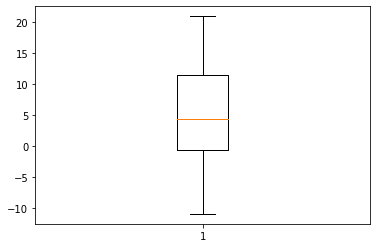

In [16]:
temp = df_wetter2_daily.avg_temp
plt.boxplot(temp)
plt.savefig("boxplot.png")

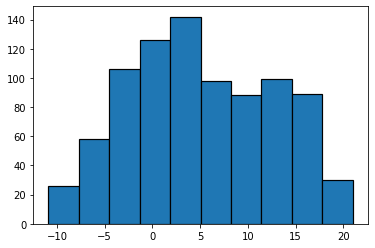

In [17]:
plt.hist(temp, edgecolor='black', linewidth=1.2)
plt.savefig("histsplot.png")

### Rain and average Temperature

In [9]:
day_source = bokeh.models.ColumnDataSource(data=df_wetter2_daily)

column_names = "avg_temp rain".split()
colors = "red blue".split()

middle = df_wetter2_daily.index[len(df_wetter2_daily)//2]
selection_range = pd.Timedelta("20 days")

# Selected-Part-Plot
p = bokeh.plotting.figure(
    height=300, 
    width=800, 
    x_axis_type="datetime", 
    x_axis_location="above", 
    x_range=(middle-selection_range, middle+selection_range),
)

for tool in [bokeh.models.PanTool, bokeh.models.WheelZoomTool]:
    p.select_one(tool).dimensions = "width"

p.yaxis.axis_label = 'Weather'

# Overview-Plot
overview = bokeh.plotting.figure(
    title="Drag the middle and edges of the selection box to change the range above",
    height=130, 
    width=800, 
    y_range=p.y_range,
    x_axis_type="datetime",
    y_axis_type=None,
    tools="hover", 
    toolbar_location=None, 
)

for fig in [p, overview]:
    fig.extra_y_ranges['rain'] = bokeh.models.Range1d(0, 5, bounds=(0, None))
    
    fig.vbar(
        x='date',
        top="rain",
        source=day_source,    
        color="#0072B2",
        legend_label="Rain",
        width=pd.Timedelta(hours=20),
        y_range_name="rain",
    )

    fig.line(
        x='date',
        y="avg_temp",
        source=day_source,    
        color="#D55E00",
        legend_label="Temperature",
    )

ax2 = bokeh.models.LinearAxis(y_range_name="rain", axis_label="rain [mm/h]")
ax2.axis_label_text_color ="navy"
p.add_layout(ax2, 'right')
    
p.legend.location = "top_left"

range_tool = bokeh.models.RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

overview.ygrid.grid_line_color = None
overview.add_tools(range_tool)

line_fig = bokeh.layouts.column(p, overview)

bokeh.plotting.show(line_fig)